# Điều chuẩn

Thời lượng ước tính: **60** phút

Chào mừng đến với lab thứ hai của mô-đun này. Các mô hình Deep Learning có nhiều tính linh hoạt và năng suất đến mức **quá khớp (overfitting) có thể là một vấn đề nghiêm trọng** nếu tập dữ liệu huấn luyện không đủ lớn. Chắc chắn nó hoạt động tốt trên tập huấn luyện, nhưng mạng đã học **không khái quát thành các ví dụ mới** mà nó chưa bao giờ thấy!

**Bạn sẽ học được:** Sử dụng regularization (điều chuẩn) trong các mô hình deep learning của mình.

Trước tiên, hãy nhập thư viện chúng ta sẽ sử dụng. 

In [ ]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Trình bày bài toán**: Bạn vừa được Liên đoàn Bóng đá Pháp thuê làm chuyên gia về AI. Họ muốn bạn giới thiệu những vị trí mà thủ môn đội tuyển Pháp sút để các cầu thủ của họ có thể đánh đầu.

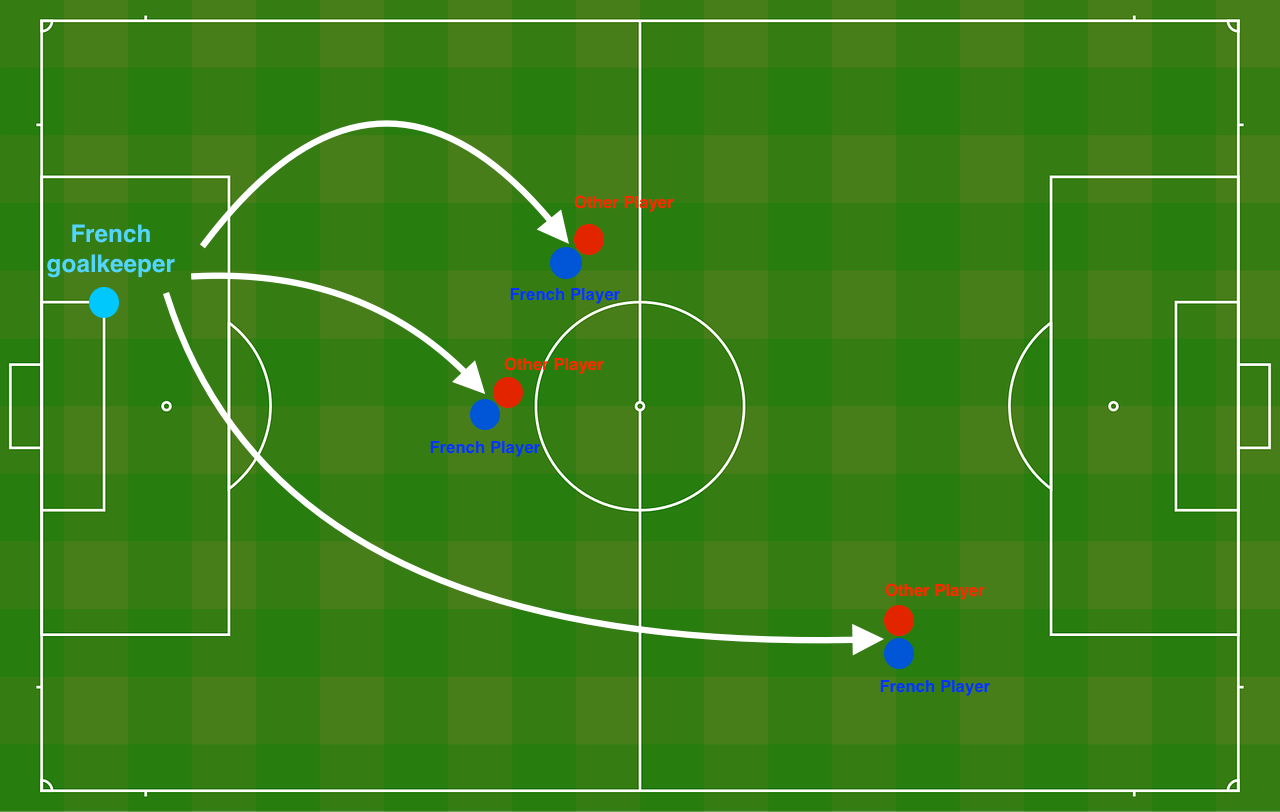
**Hình 1** </u>: **Sân bóng đá**<br> Thủ môn sút bóng lên trời, các cầu thủ của mỗi đội tranh nhau sút bóng bằng đầu của họ

Họ cung cấp cho bạn tập dữ liệu 2D sau đây từ 10 trận trước đây của Pháp. 

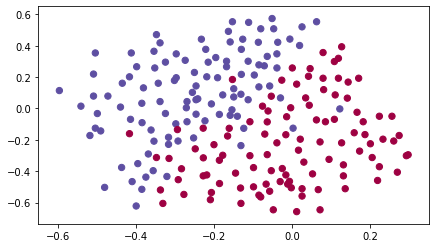

In [ ]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Mỗi chấm tương ứng với một vị trí trên sân bóng nơi cầu thủ bóng đá dùng đầu đánh bóng sau khi thủ môn Pháp đã sút bóng từ bên trái sân.
- Các chấm màu xanh dương là cầu thủ Pháp đã đánh bóng bằng đầu
- Các chấm màu đỏ là cầu thủ của đội kia đã đánh bóng bằng đầu

**Mục tiêu của bạn**: Sử dụng mô hình deep learning để tìm các vị trí trên sân mà thủ môn sẽ sút bóng. 

**Phân tích tập dữ liệu**: Tập dữ liệu này hơi sặc sỡ, nhưng dường như có một đường chéo ngăn cách nửa trên bên trái (xanh dương) với nửa dưới bên phải (đỏ) hoạt động tốt.

Trước tiên, bạn sẽ thử một mô hình không điều chuẩn (non-regularized). Sau đó, bạn sẽ học cách điều chỉnh nó và quyết định sẽ chọn mô hình nào để giải quyết bài toán của Liên đoàn Bóng đá Pháp.

## 1 - Mô hình không điều chuẩn (Non-regularized model)

Bạn sẽ sử dụng mạng nơ-ron sau (đã được triển khai cho bạn bên dưới). Mô hình này có thể được sử dụng:
- trong *regularization mode* -- bằng cách đặt input `lambd` thành giá trị khác 0. Chúng ta sử dụng "`lambd`" thay vì "`lambda`" vì "`lambda`" là một từ khóa dành riêng trong Python.  
- trong *dropout mode* -- bằng cách đặt `keep_prob` thành giá trị nhỏ hơn 1 

Đầu tiên bạn sẽ thử mô hình mà không có bất kỳ regularization nào. Sau đó, bạn sẽ thực hiện:
- Hàm *L2 regularization*: "`compute_cost_with_regularization()`" và "`backward_propagation_with_regularization()`"
- Hàm *Dropout*: "`forward_propagation_with_dropout()`" và "`backward_propagation_with_dropout()`"

Trong mỗi phần, bạn sẽ chạy mô hình này với các input chính xác để nó gọi các hàm bạn đã triển khai. Hãy xem đoạn code dưới đây để làm quen với mô hình.

In [ ]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
   Triển khai mạng nơ-ron 3 lớp: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Đối số:
    X -- dữ liệu đầu vào có shape (kích thước đầu vào, số ví dụ)
    Y -- vectơ true "label" (1 cho chấm xanh / 0 cho chấm đỏ), có shape (kích thước đầu ra, số ví dụ)
    learning_rate -- tốc độ học của tối ưu hóa
    num_iterations -- số lần lặp của vòng lặp tối ưu
    print_cost -- nếu True, in ra cost sau mỗi 100 lần lặp
    lambd -- siêu tham số điều chuẩn, số vô hướng 
    keep_prob - xác suất duy trì một nơ-ron hoạt động trong khi drop-out, số vô hướng.
    
    Trả về:
    parameters -- các tham sô mà mô hình đã tìm hiểu. Có thể sử dụng để dự đoán sau đó.
    """
        
    grads = {}
    costs = []                            # theo dõi cost
    m = X.shape[1]                        # số ví dụ
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Khởi tạo dictionary parameters.
    parameters = initialize_parameters(layers_dims)

    # Vòng lặp (gradient descent)

    for i in range(0, num_iterations):

        # Lan truyền xuôi: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Hàm chi phí
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Lan truyền ngược.
        assert(lambd==0 or keep_prob==1)    # có thể sử dụng cả L2 regularization và dropout, 
                                            # nhưng ở lab này, chúng ta sẽ chỉ khám phá lần lượt từng cái
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Cập nhật tham số.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # In ra loss sau mỗi 1000 lần lặp
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # vẽ biểu đồ của cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Hãy huấn luyện mô hình mà không cần bất kỳ regularization nào và quan sát độ chính xác trên các tập huấn luyện/thử nghiệm.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572419
Cost after iteration 20000: 0.13851642423239133


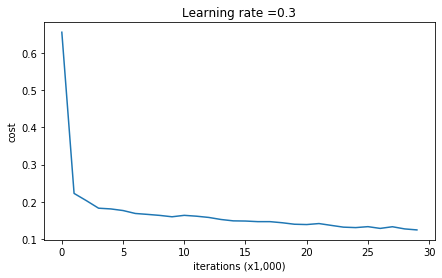

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [ ]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Train accuracy là 94.8% trong khi test accuracy là 91.5%. Đây là **mô hình cơ sở** (bạn sẽ quan sát tác động của regularization đối với mô hình này). Chạy đoạn code sau để vẽ ranh giới quyết định cho mô hình của bạn. 

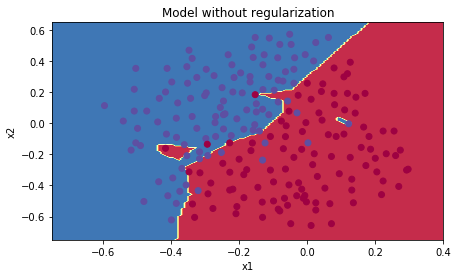

In [ ]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Mô hình không điều chuẩn rõ ràng quá khớp tập huấn luyện. Nó phù hợp với những điểm màu sặc sỡ! Bây giờ chúng ta hãy xem xét 2 kỹ thuật giảm sự quá khớp (overfitting).

## 2 - L2 Regularization 

Cách tiêu chuẩn để tránh overfitting được gọi là **L2 regularization**. Nó bao gồm việc sửa đổi một cách thích hợp hàm mất mát, từ:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
Tới:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Hãy sửa đổi cost và quan sát hệ quả.

**Task 1**: Triển khai `compute_cost_with_regularization()` để tính toán cost cho bởi công thức (2). Để tính $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , hãy sử dụng::
```python
np.sum(np.square(Wl))
```
Lưu ý rằng bạn phải thực hiện điều này với $W^{[1]}$, $W^{[2]}$ và $W^{[3]}$, sau đó tính tổng 3 số hạng và nhân với $ \frac{1}{m} \frac{\lambda}{2} $.

In [ ]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Triển khai hàm chi phí với L2 regularization. Xem công thức (2) ở trên.
    
    Đối số:
    A3 -- hậu kích hoạt, đầu ra của lan truyền xuôi có shape (kích thước đầu ra, số ví dụ)
    Y -- vectơ "true" label, có shape (kích thước đầu ra, số ví dụ)
    parameters -- dictionary của python chứa các tham số của mô hình 
    
    Trả về:
    cost - giá trị của hàm mất mát có điều chuẩn (công thức (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # cho phần cross-entropy của cost
    
    ### BẮT ĐẦU CODE Ở ĐÂY ### (khoảng 1 dòng code)
    L2_regularization_cost = None
    ### KẾT THÚC CODE Ở ĐÂY ###
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [ ]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


**Kỳ vọng đầu ra**: 

<table> 
    <tr>
    <td>
    **cost**
    </td>
        <td>
    1.78648594516
    </td>
    
    </tr>

</table> 

Tất nhiên, vì bạn đã thay đổi cost nên bạn cũng phải thay đổi lan truyền ngược (backward propagation)! Tất cả các gradient phải được tính toán theo cost mới này.

**Task 2**: Thực hiện các thay đổi cần thiết trong quá trình lan truyền ngược để tính đến regularization. Các thay đổi chỉ liên quan đến dW1, dW2 và dW3. Đối với mỗi thứ, bạn phải thêm gradient của số hạng regularization ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [ ]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Triển khai lan truyền ngược của mô hình cơ sở đã thêm L2 regularization.
    
    Đối số:
    X -- tập dữ liệu đầu vào có shape (kích thước đầu vào, số ví dụ)
    Y -- vectơ "true" có shape (kích thước đầu ra, số ví dụ)
    cache -- đầu ra cache từ forward_propagation()
    lambd -- siêu tham số điều chuẩn, số vô hướng
    
    Trả về:
    gradients -- Một dictionary với gradient descent liên quan tới từng tham số, biến kích hoạt và tiền kích hoạt 
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    ### BẮT ĐẦU CODE Ở ĐÂY ### (khoảng 1 dòng code)
    dW3 = 1./m * np.dot(dZ3, A2.T) + None
    ### KẾT THÚC CODE Ở ĐÂY ###
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    ### BẮT ĐẦU CODE Ở ĐÂY ### (khoảng 1 dòng code)
    dW2 = 1./m * np.dot(dZ2, A1.T) + None
    ### KẾT THÚC CODE Ở ĐÂY ###
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    ### BẮT ĐẦU CODE Ở ĐÂY ### (khoảng 1 dòng code)
    dW1 = 1./m * np.dot(dZ1, X.T) + None
    ### KẾT THÚC CODE Ở ĐÂY ###
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [ ]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


**Kỳ vọng đầu ra**:

<table> 
    <tr>
    <td>
    **dW1**
    </td>
        <td>
    [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
    </td>
    </tr>
    <tr>
    <td>
    **dW2**
    </td>
        <td>
    [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
    </td>
    </tr>
    <tr>
    <td>
    **dW3**
    </td>
        <td>
    [[-1.77691347 -0.11832879 -0.09397446]]
    </td>
    </tr>
</table> 

Bây giờ hãy chạy mô hình với L2 regularization $(\lambda = 0.7)$. Hàm `model()` sẽ gọi: 
- `compute_cost_with_regularization` thay vì `compute_cost`
- `backward_propagation_with_regularization` thay vì `backward_propagation`

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


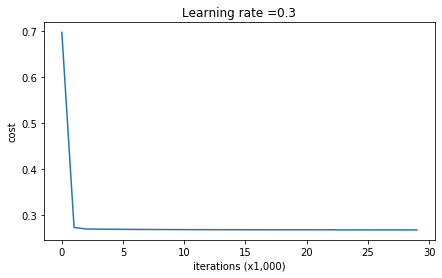

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [ ]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Xin chúc mừng, độ chính xác của tập thử nghiệm đã tăng lên đến 93%. Bạn đã cứu đội bóng đá Pháp!

Bạn không còn quá khớp dữ liệu huấn luyện nữa. Hãy vẽ ranh giới quyết định.

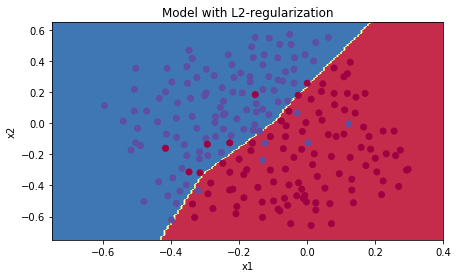

In [ ]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Quan sát**:
- Giá trị của $\lambda$ là một siêu tham số (hyperparameter) mà bạn có thể điều chỉnh bằng cách sử dụng một tập dev. 
- L2 regularization làm cho ranh giới quyết định của bạn trơn tru hơn. Nếu $\lambda$ quá lớn, thì nó cũng có thể bị "vượt quá", dẫn đến mô hình có bias cao.

**L2-regularization thực sự đang làm gì?**:

L2-regularization dựa trên giả định rằng mô hình có trọng số nhỏ đơn giản hơn một mô hình có trọng số lớn. Do đó, bằng cách phạt các giá trị bình phương của các trọng số trong hàm mất mát, bạn điều chỉnh tất cả các trọng số thành các giá trị nhỏ hơn. Để cost để có trọng số lớn hơn rất tốn! Điều này dẫn đến một mô hình trơn tru hơn, trong đó output thay đổi chậm hơn khi input thay đổi.

**Điều bạn cần nhớ** -- ý nghĩa của L2-regularization đối với:
- Tính cost:
    - Thêm 1 số hạng regularization vào cost
- Hàm truyền ngược:
    - Có các số hạng bổ sung trong gradient liên quan đến ma trận trọng số
- Trọng số kết thúc nhỏ hơn ("weight decay"):
    - Trọng số được đẩy về giá trị nhỏ hơn.

## 3 - Dropout

Cuối cùng, **dropout** là một kỹ thuật điều chuẩn dành riêng cho deep learning.
**Nó sẽ tắt ngẫu nhiên một số nơ-ron trong mỗi lần lặp lại.** Hãy xem 2 video sau để hiểu rõ!

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 


<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Hình 2 </u>: Drop-out ở lớp ẩn thứ 2. <br> Tại mỗi lần lặp, bạn tắt (= đặt thành 0) từng nơ-ron của lớp với xác suất $1 - keep\_prob$ hoặc giữ nguyên với xác suất $keep\_prob$ (50% ở đây). Các nơ-ron bị loại bỏ không đóng góp vào việc huấn luyện trong cả quá trình truyền xuôi và truyền ngược của lặp lại.</center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> Hình 3 </u>: Drop-out ở lớp ẩn thứ nhất và thứ 3. <br>Lớp thứ $1$: tắt trung bình 40% nơ-ron. Lớp thứ $3$: tắt trung bình 20% nơ-ron. </center></caption>


Khi đóng một số nơ-ron, bạn sẽ thực sự sửa đổi mô hình của mình. Ý tưởng đằng sau drop-out là ở mỗi lần lặp lại, bạn huấn luyện một mô hình khác nhau chỉ sử dụng một tập hợp con các nơ-ron. Nếu không có dropout, các nơ-ron trở nên ít nhạy cảm hơn với sự kích hoạt của một nơ-ron cụ thể khác, bởi vì nơ-ron khác đó có thể bị tắt bất cứ lúc nào.

### 3.1 - Truyền xuôi mà không có dropout

**Task 3**: Thực hiện truyền xuôi với dropout. Bạn đang sử dụng mạng nơ-ron 3 lớp và sẽ thêm dropout cho lớp ẩn thứ nhất và thứ hai. Chúng ta sẽ không áp dụng dropout đối với lớp input hoặc lớp output.

**Hướng dẫn**:
Bạn muốn tắt một số nơ-ron ở lớp thứ nhất và lớp thứ hai. Để làm điều đó, bạn sẽ thực hiện 4 Bước:
1. Trong bài giảng, chúng ta đã tạo một biến $d^{[1]}$ có shape là $a^{[1]}$ sử dụng `np.random.rand()` để lấy ngẫu nhiên các số từ 0 đến 1. Ở đây, bạn sẽ sử dụng triển khai vector hóa, vì vậy hãy tạo ma trận ngẫu nhiên $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ có cùng chiều với $A^{[1]}$.
2. Thiết lập mỗi mục nhập của $D^{[1]}$ thành 0 với xác suất (`1-keep_prob`) hoặc 1 với xác suất (`keep_prob`), bằng cách lập ngưỡng giá trị trong $D^{[1]}$ thích hợp. Gợi ý: đặt tất cả các mục của ma trận X thành 0 (nếu mục nhập nhỏ hơn 0,5) hoặc 1 (nếu mục nhập lớn hơn 0,5), bạn sẽ thực hiện: `X = (X < 0.5)`. Lưu ý rằng 0 và 1 tương ứng với False và True.
3. Đặt $A^{[1]}$ thành $A^{[1]} * D^{[1]}$. (Bạn có thể đang tắt một số nơ-ron). Bạn có thể coi $D^{[1]}$ như một mask, để khi nó được nhân với một ma trận khác, nó sẽ tắt một số giá trị.
4. Chia $A^{[1]}$ cho `keep_prob`. Làm như vậy sẽ bảo đảm rằng kết quả của cost cũng sẽ có giá trị mong đợi như khi không có drop-out. (Kỹ thuật này được gọi là inverted dropout.)

In [ ]:
# GRADED FUNCTION: forward_propagation_with_dropout

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Triển khai lan truyền xuôi: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Đối số:
    X -- tập dữ liệu đầu vào, có shape (2, số ví dụ)
    parameters -- dictionary của python chứa các tham số "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- ma trận trọng số có shape (20, 2)
                    b1 -- vectơ bias có shape (20, 1)
                    W2 -- ma trận trọng số có shape (3, 20)
                    b2 -- vectơ bias có shape (3, 1)
                    W3 -- ma trận trọng số có shape (1, 3)
                    b3 -- vectơ bias có shape (1, 1)
    keep_prob - xác suất duy trì một nơ-ron hoạt động trong khi drop-out, số vô hướng
    
    Trả về:
    A3 -- giá trị kích hoạt cuối, đầu ra của lan truyền xuôi, có shape (1,1)
    cache -- tuple, thông tin được lưu trữ để tính toán lan truyền xuôi
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    ### BẮT ĐẦU CODE Ở ĐÂY ### (khoảng 4 dòng)         # Các bước 1-4 dưới đây tương ứng với các bước 1-4 đã mô tả ở trên. 
    D1 = None                                         # Bước 1: khởi tạo ma trận D1 = np.random.rand(..., ...)
    D1 = None                                         # Bước 2: chuyển các entry của D1 thành 0 hoặc 1 (dùng keep_prob làm ngưỡng)
    A1 = None                                         # Bước 3: dừng các nơ-ron của A1
    A1 = None                                         # Bước 4: chia tỷ lệ giá trị các nơ-ron chưa dừng
    ### KẾT THÚC CODE Ở ĐÂY ###
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    ### BẮT ĐẦU CODE Ở ĐÂY ### (khoảng 4 dòng)
    D2 = None                                         # Bước 1: khởi tạo ma trận D2 = np.random.rand(..., ...)
    D2 = None                                         # Bước 2: chuyển các entry của D2 thành 0 hoặc 1 (dùng keep_prob làm ngưỡng)
    A2 = None                                         # Bước 3: dừng các nơ-ron của A2
    A2 = None                                         # Bước 4: chia tỷ lệ giá trị các nơ-ron chưa dừng
    ### KẾT THÚC CODE Ở ĐÂY ###
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [ ]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


**Kỳ vọng đầu ra**: 

<table> 
  <tr>
    <td>
    **A3**
    </td>
        <td>
    [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]
    </td>
    
  </tr>

</table> 

### 3.2 - Truyền ngược với dropout

**Task 4**: Thực hiện truyền ngược với dropout. Như trước, bạn đang huấn luyện một mạng 3 lớp. Thêm dropout cho lớp ẩn đầu tiên và thứ hai, sử dụng các mask $ D ^ {[1]} $ và $ D ^ {[2]} $ được lưu trữ trong cache.

**Hướng dẫn**:
Truyền ngược với dropout thực sự khá dễ dàng. Bạn sẽ phải thực hiện 2 bước:
1. Trước đây bạn đã đóng một số nơ-ron trong quá trình truyền ngược, bằng cách áp dụng mask $ D ^ {[1]} $ cho `A1`. Trong truyền ngược, bạn sẽ phải đóng các nơ-ron tương tự bằng cách áp dụng lại cùng mask $ D ^ {[1]} $ cho `dA1`.
2. Trong quá trình truyền xuôi, bạn đã chia `A1` cho `keep_prob`. Do dó trong truyền ngược, bạn sẽ phải chia lại `dA1` cho `keep_prob` (giải thích tính toán là nếu $ A ^ {[1]} $ được chia tỷ lệ bởi cùng `keep_prob`, thì đạo hàm của nó là $ dA ^ {[1 ]} $ cũng được chia tỷ lệ bởi cùng một `keep_prob`).


In [ ]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Triển khai lan truyên ngược của mô hình cơ sở đã thêm dropout.
    
    Đối số:
    X -- tập dữ liệu đầu vào, có shape (2, số ví dụ)
    Y -- vectơ "true" label, có shape (kích thước đầu ra, số ví dụ)
    cache -- đầu ra cache từ forward_propagation_with_dropout()
    keep_prob - xác suất duy trì một nơ-ron hoạt động trong khi drop-out, số vô hướng
    
    Trả về:
    gradients -- Một dictionary với gradient descent liên quan tới từng tham số, biến kích hoạt và tiền kích hoạt 
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
    dA2 = None              # Bước 1: Áp dụng mask D2 để dừng các nơ-ron tương tự như trong lan truyền xuôi
    dA2 = None              # Bước 2: chia tỷ lệ giá trị các nơ-ron chưa dừng
    ### KẾT THÚC CODE Ở ĐÂY ###
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
    dA1 = None              # Bước 1: Áp dụng mask D1 để dừng các nơ-ron tương tự như trong lan truyền xuôi
    dA1 = None              # Bước 2: chia tỷ lệ giá trị các nơ-ron chưa dừng
    ### KẾT THÚC CODE Ở ĐÂY ###
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [ ]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


**Kỳ vọng đầu ra**: 

<table> 
  <tr>
  <td>
  **dA1**
  </td>
      <td>
  [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
[ 0.65515713  0.         -0.00337459  0.         -0.        ]]
  </td>
  
  </tr>
  <tr>
  <td>
  **dA2**
  </td>
      <td>
  [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
[ 0.          0.53159854 -0.          0.53159854 -0.34089673]
[ 0.          0.         -0.00292733  0.         -0.        ]]
  </td>
  
  </tr>
</table> 

Bây giờ hãy chạy mô hình với droppout (`keep_prob = 0.86`). Điều này có nghĩa là ở mỗi lần lặp lại, bạn đóng từng nơ-ron của lớp 1 và lớp 2 với xác suất 24%. Giờ hàm `model()` sẽ gọi:
- `forward_propagation_with_dropout` thay vì `forward_propagation`.
- `backward_propagation_with_dropout` thay vì `backward_propagation`.

In [ ]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Dropout hoạt động rất tuyệt! Test accuracy đã tăng trở lại (lên đến 95%)! Mô hình của bạn không quá phù hợp với tập huấn luyện và thực hiện rất tốt trong tập thử nghiệm. Đội tuyển bóng đá Pháp sẽ mãi mãi biết ơn các bạn!

Chạy code bên dưới để vẽ ranh giới quyết định.

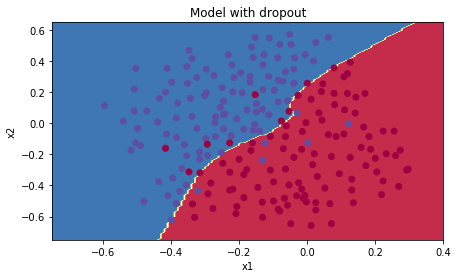

In [ ]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Lưu ý**:
- Một **lỗi phổ biến** khi sử dụng droppout là sử dụng nó trong cả huấn luyện và thử nghiệm. Bạn chỉ nên sử dụng droppout (loại bỏ ngẫu nhiên các nút) trong huấn luyện.
- Các framework deep learning như [tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [keras](https://keras.io/layers/core/#dropout) hay [caffe](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) đi kèm với việc triển khai lớp dropout. Đừng căng thẳng - bạn sẽ sớm học được một số framework này.

<font color='blue'>
    
**Những điều bạn cần nhớ về dropout:**
    
- Dropout là một kỹ thuật regularization. 
- Bạn chỉ sử dụng dropout trong quá trình huấn luyện. Không sử dụng dropout (loại bỏ ngẫu nhiên các nút) trong thời gian thử nghiệm.
- Áp dụng dropout cho cả quá trình truyền xuôi và ngược.
- Trong thời gian huấn luyện, hãy chia từng lớp dropout cho keep_prob để giữ nguyên giá trị mong đợi cho các lần kích hoạt. Ví dụ: nếu keep_prob là 0,5, thì trung bình chúng ta sẽ đóng một nửa số nút, vì vậy output sẽ được chia tỷ lệ 0,5 vì chỉ một nửa còn lại đang đóng góp vào giải pháp. Chia cho 0,5 tương đương với nhân với 2. Do đó, output bây giờ có giá trị mong đợi tương tự. Bạn có thể kiểm tra xem điều này có hoạt động ngay cả khi keep_prob là các giá trị khác 0,5. 

## 4 - Tổng kết

**Đây là kết quả của 3 mô hình**: 

<table> 
  <tr>
      <td>
      **model**
      </td>
      <td>
      **train accuracy**
      </td>
      <td>
      **test accuracy**
      </td>

  </tr>
      <td>
      3-layer NN without regularization
      </td>
      <td>
      95%
      </td>
      <td>
      91.5%
      </td>
  <tr>
      <td>
      3-layer NN with L2-regularization
      </td>
      <td>
      94%
      </td>
      <td>
      93%
      </td>
  </tr>
  <tr>
      <td>
      3-layer NN with dropout
      </td>
      <td>
      93%
      </td>
      <td>
      95%
      </td>
  </tr>
</table> 

Lưu ý rằng regularization làm tổn hại đến hiệu suất tập huấn luyện! Điều này là do nó hạn chế khả năng qua khớp tập huấn luyện của mạng. Nhưng vì cuối cùng nó mang lại test accuracy tốt hơn, nên nó vẫn giúp ích cho hệ thống của bạn.

Chúc mừng bạn đã hoàn thành lab này! Và cũng vì cách mạng hóa bóng đá Pháp. :-)

<font color='blue'>
    
**Những điều chúng tôi muốn bạn nhớ từ notebook này:**:
    
- Regularization giúp bạn giảm overfitting.
- Regularization sẽ đẩy trọng số của bạn xuống các giá trị thấp hơn.
- L2 regularization và Dropout là 2 kỹ thuật regularization rất hiệu quả.